# Sentiment Classification Model 3

 Trained on IMDB dataset, predicts on WW2 Bunker Reviews

### 1. Import Dependencies

In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




### 2. Load Data

In [3]:
df = pd.read_pickle("../data/processed/processed_movie_reviews.pkl")
df.head()

,review,sentiment,clean_text,tokens
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...,"{'input_ids': [101, 2028, 1997, 1996, 2060, 15..."
1,A wonderful little production. <br /><br />The...,1,A wonderful little production. The filming tec...,"{'input_ids': [101, 1037, 6919, 2210, 2537, 10..."
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...,"{'input_ids': [101, 1045, 2245, 2023, 2001, 10..."
3,Basically there's a family where a little boy ...,0,Basically there's a family where a little boy ...,"{'input_ids': [101, 10468, 2045, 1005, 1055, 1..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,Petter Mattei's Love in the Time of Money is a...,"{'input_ids': [101, 9004, 3334, 4717, 7416, 10..."


### 3. Prepare Train/Validation Splits

In [4]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_text"], df["sentiment"], test_size=0.2, random_state=42
)

### 4. Create a Dataset Class

In [5]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist() if hasattr(texts, "tolist") else texts
        self.labels = labels.tolist() if hasattr(labels, "tolist") else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        return item


### 5. Instansiate Tokenizer & Dataset

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

### 6. Initialize Model and Trainer

In [7]:
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

training_args = TrainingArguments(
    output_dir="outputs3",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="logs",
    logging_steps=50,
    bf16 = True if torch.backends.mps.is_available() else False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/lib/python3.13/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### 7. Train

In [8]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.359800,0.339819
2,0.245900,0.454203
3,0.159400,0.509126


TrainOutput(global_step=15000, training_loss=0.283557382106781, metrics={'train_runtime': 12545.4311, 'train_samples_per_second': 9.565, 'train_steps_per_second': 1.196, 'total_flos': 7893331660800000.0, 'train_loss': 0.283557382106781, 'epoch': 3.0})

In [9]:
# If you've already saved the final model or a checkpoint, load it:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("outputs3/checkpoint-15000")  
# or "outputs" if that’s where you saved it

# Re-initialize the Trainer with the same arguments but the loaded model:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


In [10]:
val_preds = trainer.predict(val_dataset)


In [11]:
import numpy as np

logits = val_preds.predictions
labels = val_preds.label_ids

# Argmax over logits to get predicted class (0 or 1)
preds = np.argmax(logits, axis=1)

accuracy = (preds == labels).mean()


from sklearn.metrics import accuracy_score, precision_recall_fscore_support

acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1:         {f1:.4f}")


Accuracy:   0.8905
Precision:  0.8981
Recall:     0.8829
F1:         0.8904


[[4456  505]
 [ 590 4449]]


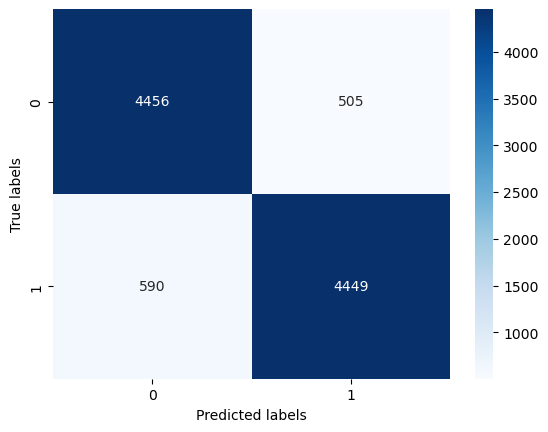

In [12]:
from sklearn.metrics import confusion_matrix

# `labels` = ground-truth labels (0 or 1)
# `preds` = predicted labels (0 or 1)

cm = confusion_matrix(labels, preds)
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
plt.show()



### 8. Evaluate

In [13]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.5091256499290466, 'eval_model_preparation_time': 0.0044, 'eval_runtime': 258.9356, 'eval_samples_per_second': 38.62, 'eval_steps_per_second': 4.827}


### 10. Predict on Unlabeled Data

In [14]:
model = BertForSequenceClassification.from_pretrained("outputs/checkpoint-15000")  # Adjust to your checkpoint path
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

df_test = pd.read_pickle("../data/processed/bunker_test_set_tokenized.pkl")

class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = df["clean_text"].tolist()
        self.tokenizer = tokenizer
        self.max_length = 512  
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze()
        }

inference_dataset = InferenceDataset(df_test)

training_args = TrainingArguments(
    output_dir="outputs",
    per_device_eval_batch_size=8
)
trainer = Trainer(
    model=model,
    args=training_args
)

predictions_output = trainer.predict(inference_dataset)
logits = predictions_output.predictions  # shape: (num_samples, 2)

probs = F.softmax(torch.tensor(logits), dim=1).numpy()

# Neutral threshold
threshold = 0.9

# Map binary predictions into three classes:
final_preds = []
for p in probs:
    if p.max() < threshold:
        final_preds.append("neutral")
    elif p.argmax() == 1:
        final_preds.append("positive")
    else:
        final_preds.append("negative")

df_test["predicted_sentiment"] = final_preds

df_test = df_test[["clean_text", "manual_classification", "predicted_sentiment", "tokens"]]

df_test.to_csv("../data/processed/bunker_predictions.csv", index=False)
print("Predictions saved to data/processed/bunker_predictions.csv")


Predictions saved to data/processed/bunker_predictions.csv


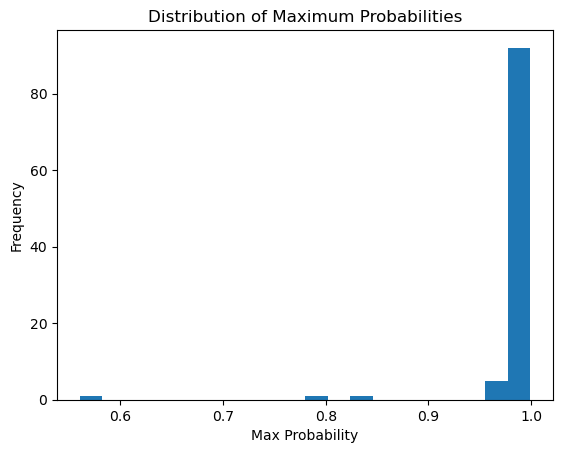

In [15]:
import matplotlib.pyplot as plt

max_probs = [p.max() for p in probs]
plt.hist(max_probs, bins=20)
plt.xlabel("Max Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Probabilities")
plt.show()


In [16]:
df_test = pd.read_csv("../data/processed/bunker_predictions.csv")

manual_labels = df_test["manual_classification"]
predicted_labels = df_test["predicted_sentiment"]

accuracy = accuracy_score(manual_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(manual_labels, predicted_labels, labels=["positive", "neutral", "negative"])
print("Confusion Matrix:")
print(cm)

report = classification_report(manual_labels, predicted_labels, labels=["positive", "neutral", "negative"])
print("Classification Report:")
print(report)


Accuracy: 0.7900
Confusion Matrix:
[[72  0  4]
 [10  1  3]
 [ 2  2  6]]
Classification Report:
              precision    recall  f1-score   support

    positive       0.86      0.95      0.90        76
     neutral       0.33      0.07      0.12        14
    negative       0.46      0.60      0.52        10

    accuracy                           0.79       100
   macro avg       0.55      0.54      0.51       100
weighted avg       0.74      0.79      0.75       100



In [ ]:
df_incorrect = df_test[df_test["manual_classification"] != df_test["predicted_sentiment"]]

df_incorrect.to_csv("incorrect_classifications.csv", index=False)
